In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import shape, Point
import json

# ============================================================================
# Step 1: Load rentals and extract unique neighborhoods
# ============================================================================

In [46]:
use_fine_grid = True

In [47]:
if (use_fine_grid):
    df_rentals_initial = pd.read_csv("../data/paris_rentals.csv", 
                                     delimiter=';', 
                                     on_bad_lines='skip', 
                                     encoding='utf-8')
    
    # Drop duplicates based on “Numéro du quartier”
    df_neigh = df_rentals_initial.drop_duplicates(subset="Numéro du quartier")
    
    # Keep only the neighborhood ID and its GeoJSON geometry
    df_neigh = df_neigh[["Numéro du quartier", "geo_shape"]]
    print(f"Number of unique neighborhoods: {len(df_neigh)}")
    
    # Rename for convenience
    df_neigh.rename(columns={"Numéro du quartier": "neigh_id"}, inplace=True)
    
    # Convert the geo_shape (GeoJSON) to Shapely geometry
    def convert_geojson(geo_str):
        try:
            geo_dict = json.loads(geo_str)
            return shape(geo_dict)
        except Exception as e:
            print("Error converting geometry:", e)
            return None
    
    df_neigh["geometry"] = df_neigh["geo_shape"].apply(convert_geojson)
    gdf_neigh = gpd.GeoDataFrame(df_neigh, geometry="geometry", crs="EPSG:4326")

else:
    # Read the GeoJSON file that contains your neighborhood polygons
    gdf_neigh = gpd.read_file("../data/neighbourhoods.geojson")
    
    # (Optional) If you need to match the original code later on,
    # rename a key property (for example, if the GeoJSON uses "neighbourhood")
    # to "neigh_id" so that downstream merges or joins work as before.
    gdf_neigh.rename(columns={"neighbourhood": "neigh_id"}, inplace=True)
    
    # If needed, drop duplicate geometries based on the neighborhood identifier.
    gdf_neigh = gdf_neigh.drop_duplicates(subset="neigh_id")
    
    # Now you have 'gdf_neigh' in memory with the proper CRS:
    gdf_neigh.set_crs("EPSG:4326", inplace=True)
    
    print(f"Number of unique neighborhoods: {len(gdf_neigh)}")

Number of unique neighborhoods: 80


# ============================================================================
# Step 2: Load Airbnb listings and compute Airbnb density by neighborhood
# ============================================================================

Original Airbnb data rows: 91031
Airbnb DataFrame shape: (91031, 18)
Airbnb columns: ['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm', 'license']
Total number of Airbnb listings in Paris: 91031


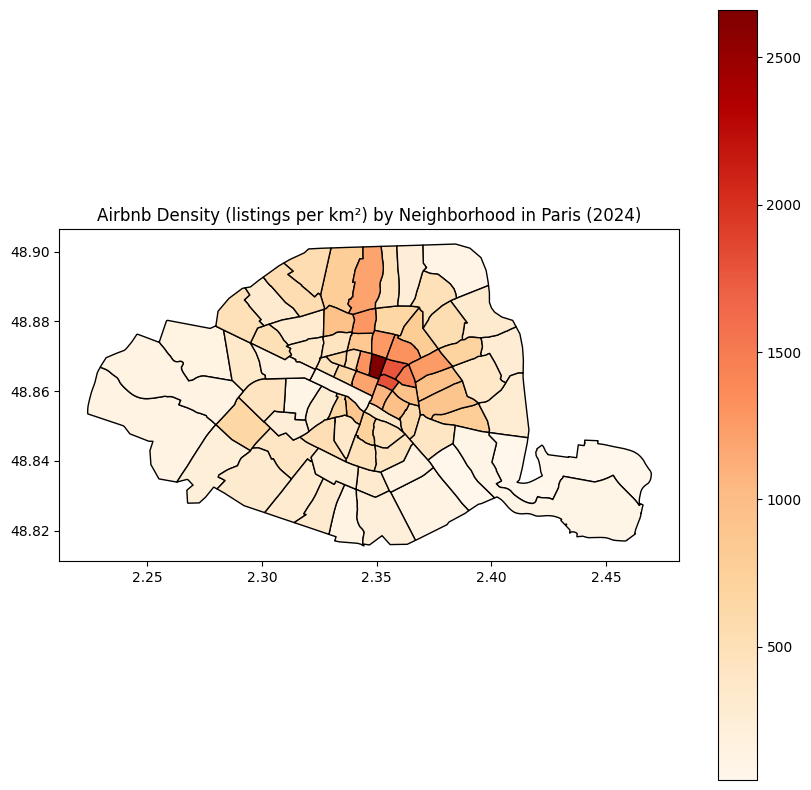


Top 5 neighborhoods by Airbnb density:
    neigh_id  airbnb_count  area_km2  airbnb_density
23         8          1729  0.649981     2660.077470
1         12           893  0.492550     1813.015072
11         9          1309  0.734577     1781.979061
24        10           930  0.627506     1482.057158
33        39          1840  1.406733     1307.995531


In [48]:
df_airbnb = pd.read_csv("../data/paris_airbnb.csv", 
                        delimiter=',', 
                        on_bad_lines='skip', 
                        encoding='utf-8')

print(f"Original Airbnb data rows: {len(df_airbnb)}")
print("Airbnb DataFrame shape:", df_airbnb.shape)
print("Airbnb columns:", list(df_airbnb.columns))

# Create geometry points from columns 6 (latitude) and 7 (longitude)
def create_point(row):
    # Ensure the row has at least 8 columns
    if len(row) >= 8:
        try:
            lon, lat = row.iloc[7], row.iloc[6]
            return Point(lon, lat)
        except Exception as e:
            print("Error creating point for row:", e)
            return None
    else:
        return None

df_airbnb['geometry'] = df_airbnb.apply(create_point, axis=1)
df_airbnb = df_airbnb[df_airbnb['geometry'].notnull()]  # filter out invalid points

gdf_airbnb = gpd.GeoDataFrame(df_airbnb, geometry='geometry', crs="EPSG:4326")

# Spatial join with neighborhoods to identify which listing falls in which neighborhood
gdf_join_airbnb = gpd.sjoin(gdf_airbnb, gdf_neigh, how='left', predicate='within')

# Count the number of listings per neighborhood
counts = gdf_join_airbnb.groupby('neigh_id').size().reset_index(name='airbnb_count')
gdf_neigh = gdf_neigh.merge(counts, on='neigh_id', how='left')
gdf_neigh['airbnb_count'] = gdf_neigh['airbnb_count'].fillna(0).astype(int)

# Calculate area in km² (by projecting to EPSG:3857) and density
gdf_neigh['area_km2'] = gdf_neigh.to_crs(epsg=3857).area / 1e6
gdf_neigh['airbnb_density'] = gdf_neigh['airbnb_count'] / gdf_neigh['area_km2']
print(f"Total number of Airbnb listings in Paris: {len(gdf_airbnb)}")

# Plot Airbnb density
fig, ax = plt.subplots(figsize=(10, 10))
gdf_neigh.plot(column='airbnb_density', cmap='OrRd', legend=True, ax=ax, edgecolor='black')
ax.set_title("Airbnb Density (listings per km²) by Neighborhood in Paris (2024)")
plt.show()

# Show top 5 neighborhoods by Airbnb density
print("\nTop 5 neighborhoods by Airbnb density:")
density_cols = ['neigh_id', 'airbnb_count', 'area_km2', 'airbnb_density']
print(gdf_neigh.sort_values('airbnb_density', ascending=False).head(5)[density_cols])

# ============================================================================
# Step 3: Filter rentals for year 2024 and compute average price by neighborhood
# ============================================================================

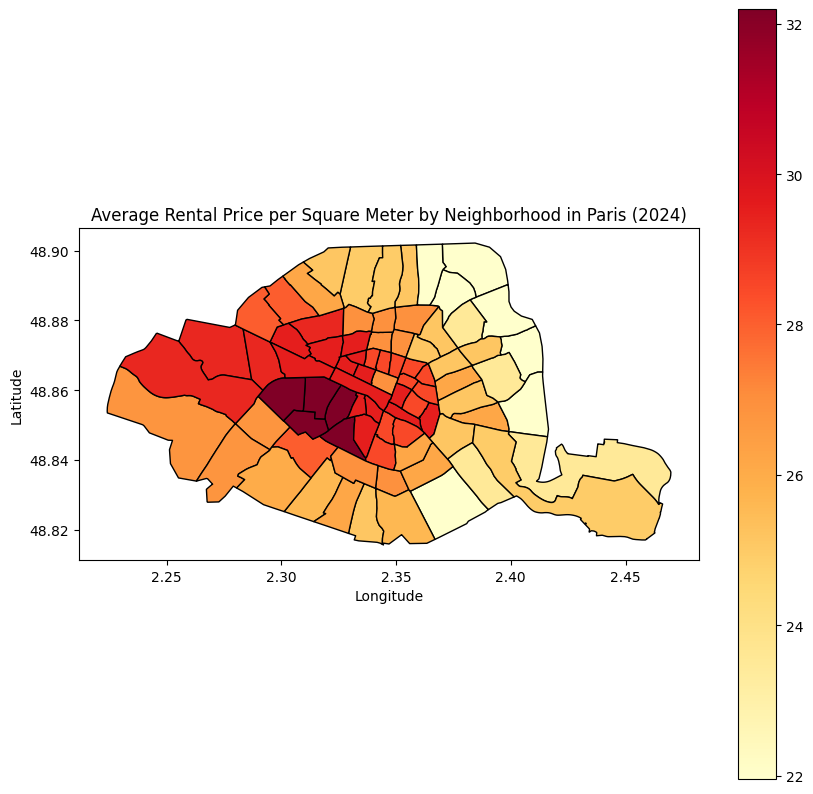

In [49]:
# Keep only rows where the first column == 2024
df_rentals_2024 = df_rentals_initial[df_rentals_initial.iloc[:, 0] == 2024].copy()

# Parse "latitude, longitude" from column index 13
def parse_coords(coord_str):
    try:
        lat_str, lon_str = coord_str.split(',')
        lat = float(lat_str.strip())
        lon = float(lon_str.strip())
        return Point(lon, lat)
    except Exception as e:
        print("Error parsing coordinates:", e)
        return None

df_rentals_2024['geometry'] = df_rentals_2024.iloc[:, 13].apply(parse_coords)

# Rental price is in column index 7
df_rentals_2024['rental_price'] = pd.to_numeric(df_rentals_2024.iloc[:, 7], errors='coerce')

# Drop rows missing geometry or rental price
df_rentals_2024 = df_rentals_2024[df_rentals_2024['geometry'].notnull() & 
                                  df_rentals_2024['rental_price'].notnull()]

gdf_rentals_2024 = gpd.GeoDataFrame(df_rentals_2024, geometry='geometry', crs="EPSG:4326")

# Spatial join to find which 2024 rentals fall in which neighborhood
gdf_join_rentals_2024 = gpd.sjoin(gdf_rentals_2024, gdf_neigh, how='left', predicate='within')

# Average rental price per neighborhood
avg_prices_2024 = gdf_join_rentals_2024.groupby('neigh_id')['rental_price'].mean().reset_index(name='avg_rental_price')
gdf_neigh = gdf_neigh.merge(avg_prices_2024, on='neigh_id', how='left')
gdf_neigh['avg_rental_price'] = gdf_neigh['avg_rental_price'].fillna(0)

# Plot the average rental price (2024)
fig2, ax2 = plt.subplots(figsize=(10, 10))
gdf_neigh.plot(column='avg_rental_price', cmap='YlOrRd', legend=True, ax=ax2, edgecolor='black')
ax2.set_title("Average Rental Price per Square Meter by Neighborhood in Paris (2024)")
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")
plt.show()

# ============================================================================
# Step 4: Any visual intuition ?
# ============================================================================

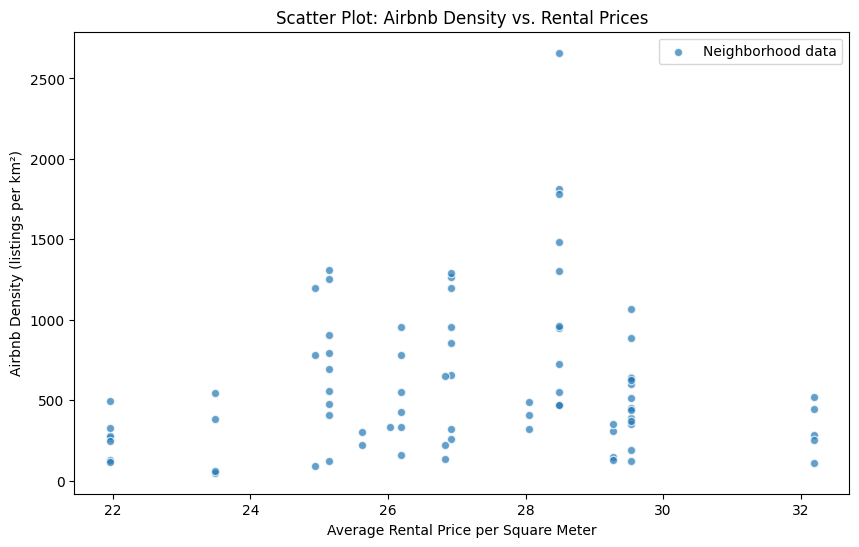

In [50]:
import numpy as np

# Prepare data: x-axis is now the average rental price, y-axis is Airbnb density
x = gdf_neigh['avg_rental_price'].values
y = gdf_neigh['airbnb_density'].values

# Compute linear regression using NumPy's polyfit
slope, intercept = np.polyfit(x, y, 1)
regression_line = slope * x + intercept

# Create the scatter plot with the regression line
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(x, y, alpha=0.7, edgecolors='w', label='Neighborhood data')

# Set axis labels and title
ax.set_xlabel("Average Rental Price per Square Meter")
ax.set_ylabel("Airbnb Density (listings per km²)")
ax.set_title("Scatter Plot: Airbnb Density vs. Rental Prices")
ax.legend()

plt.show()

In [51]:
print(gdf_neigh.columns)

Index(['neigh_id', 'geo_shape', 'geometry', 'airbnb_count', 'area_km2',
       'airbnb_density', 'avg_rental_price'],
      dtype='object')


   degree      train_mse       test_mse
0       1  209628.966500  225158.113527
1       2  186512.756788  196613.903770
2       3  185437.242329  199506.551681
3       4  181621.094586  197883.302709
4       5  173991.444246  208970.399900
5       6  172980.200714  207391.052496
6       7  171971.593412  205675.895208

Best model: Degree 2
Train MSE (bias indicator): 186512.7568
Validation MSE (overall error): 196613.9038


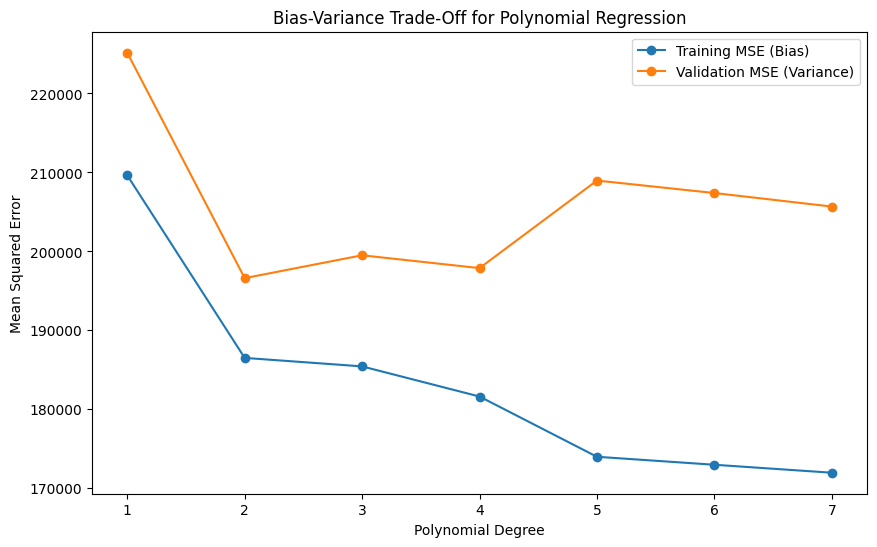

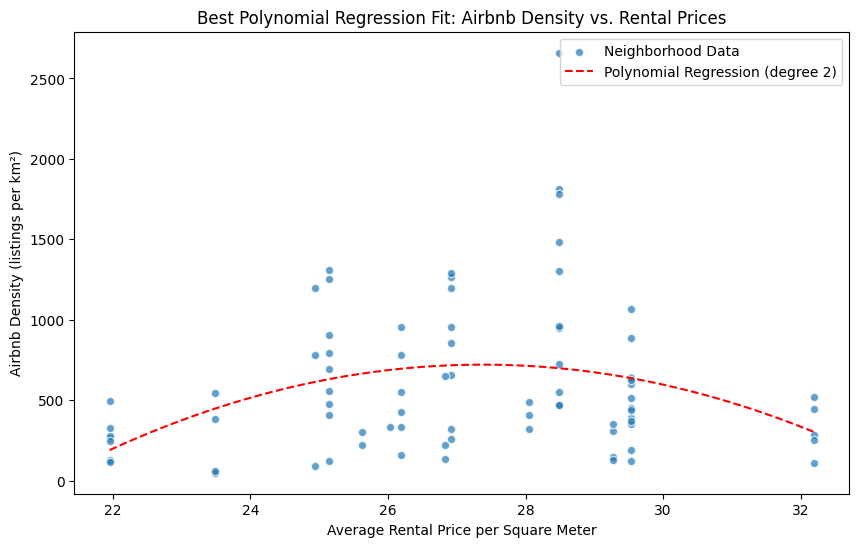

In [62]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, KFold

# ------------------------
# 1. Bias-Variance Analysis
# ------------------------
# Prepare the data: x is the average rental price, y is the Airbnb density.
x = gdf_neigh['avg_rental_price'].values.reshape(-1, 1)
y = gdf_neigh['airbnb_density'].values

degrees = range(1, 8)  # Evaluate polynomial degrees 1 to 7
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = []

# Loop over polynomial degrees and compute cross-validated training and validation MSE.
for degree in degrees:
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    x_poly = poly_features.fit_transform(x)
    
    model = LinearRegression()
    cv_results = cross_validate(
        model, x_poly, y, cv=kf, 
        scoring='neg_mean_squared_error', 
        return_train_score=True
    )
    
    # Convert negative MSE scores to positive values
    train_mse = -np.mean(cv_results['train_score'])
    test_mse  = -np.mean(cv_results['test_score'])
    
    results.append({
         'degree': degree,
         'train_mse': train_mse,
         'test_mse': test_mse
    })

results_df = pd.DataFrame(results)
print(results_df)

# Select the model with the lowest validation (test) MSE.
best_model_row = results_df.loc[results_df['test_mse'].idxmin()]
best_degree = int(best_model_row['degree'])
print(f"\nBest model: Degree {best_degree}")
print(f"Train MSE (bias indicator): {best_model_row['train_mse']:.4f}")
print(f"Validation MSE (overall error): {best_model_row['test_mse']:.4f}")

# ------------------------
# 2. Plot Bias-Variance Trade-Off
# ------------------------
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(results_df['degree'], results_df['train_mse'], marker='o', label='Training MSE (Bias)')
ax.plot(results_df['degree'], results_df['test_mse'], marker='o', label='Validation MSE (Variance)')
ax.set_xlabel('Polynomial Degree')
ax.set_ylabel('Mean Squared Error')
ax.set_title('Bias-Variance Trade-Off for Polynomial Regression')
ax.legend()
plt.show()

# ------------------------
# 3. Fit and Plot the Best Degree Model
# ------------------------
# Fit the best model on the entire dataset.
poly_features_best = PolynomialFeatures(degree=best_degree, include_bias=False)
x_poly_best = poly_features_best.fit_transform(x)
best_model = LinearRegression()
best_model.fit(x_poly_best, y)

# Generate a smooth regression curve for plotting.
x_range = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
x_range_poly = poly_features_best.transform(x_range)
y_pred = best_model.predict(x_range_poly)

# Create the scatter plot with the best model's regression curve.
fig2, ax2 = plt.subplots(figsize=(10, 6))
ax2.scatter(x, y, alpha=0.7, edgecolors='w', label='Neighborhood Data')
ax2.plot(x_range, y_pred, color='red', linestyle='--', 
         label=f'Polynomial Regression (degree {best_degree})')
ax2.set_xlabel("Average Rental Price per Square Meter")
ax2.set_ylabel("Airbnb Density (listings per km²)")
ax2.set_title("Best Polynomial Regression Fit: Airbnb Density vs. Rental Prices")
ax2.legend()

plt.show()